<a href="https://colab.research.google.com/github/soyul5458/study/blob/main/SDV_Synthesizer_Sequences_(PAR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthesize Sequences (PAR)

In this notebook, we'll use the SDV library to create multiple, synthetic sequences. The SDV uses machine learning to learn patterns from real data and emulates them when creating synthetic data.

We'll use the **PAR** algorithm to do this. PAR uses a neural network to create sequences.

# 0. Installation

Install the SDV library.

In [ ]:
%pip install sdv

**Important**: If you're using Google Colab, please restart the runtime by clicking `Runtime` in the top menu bar and then `Restart sesssion`

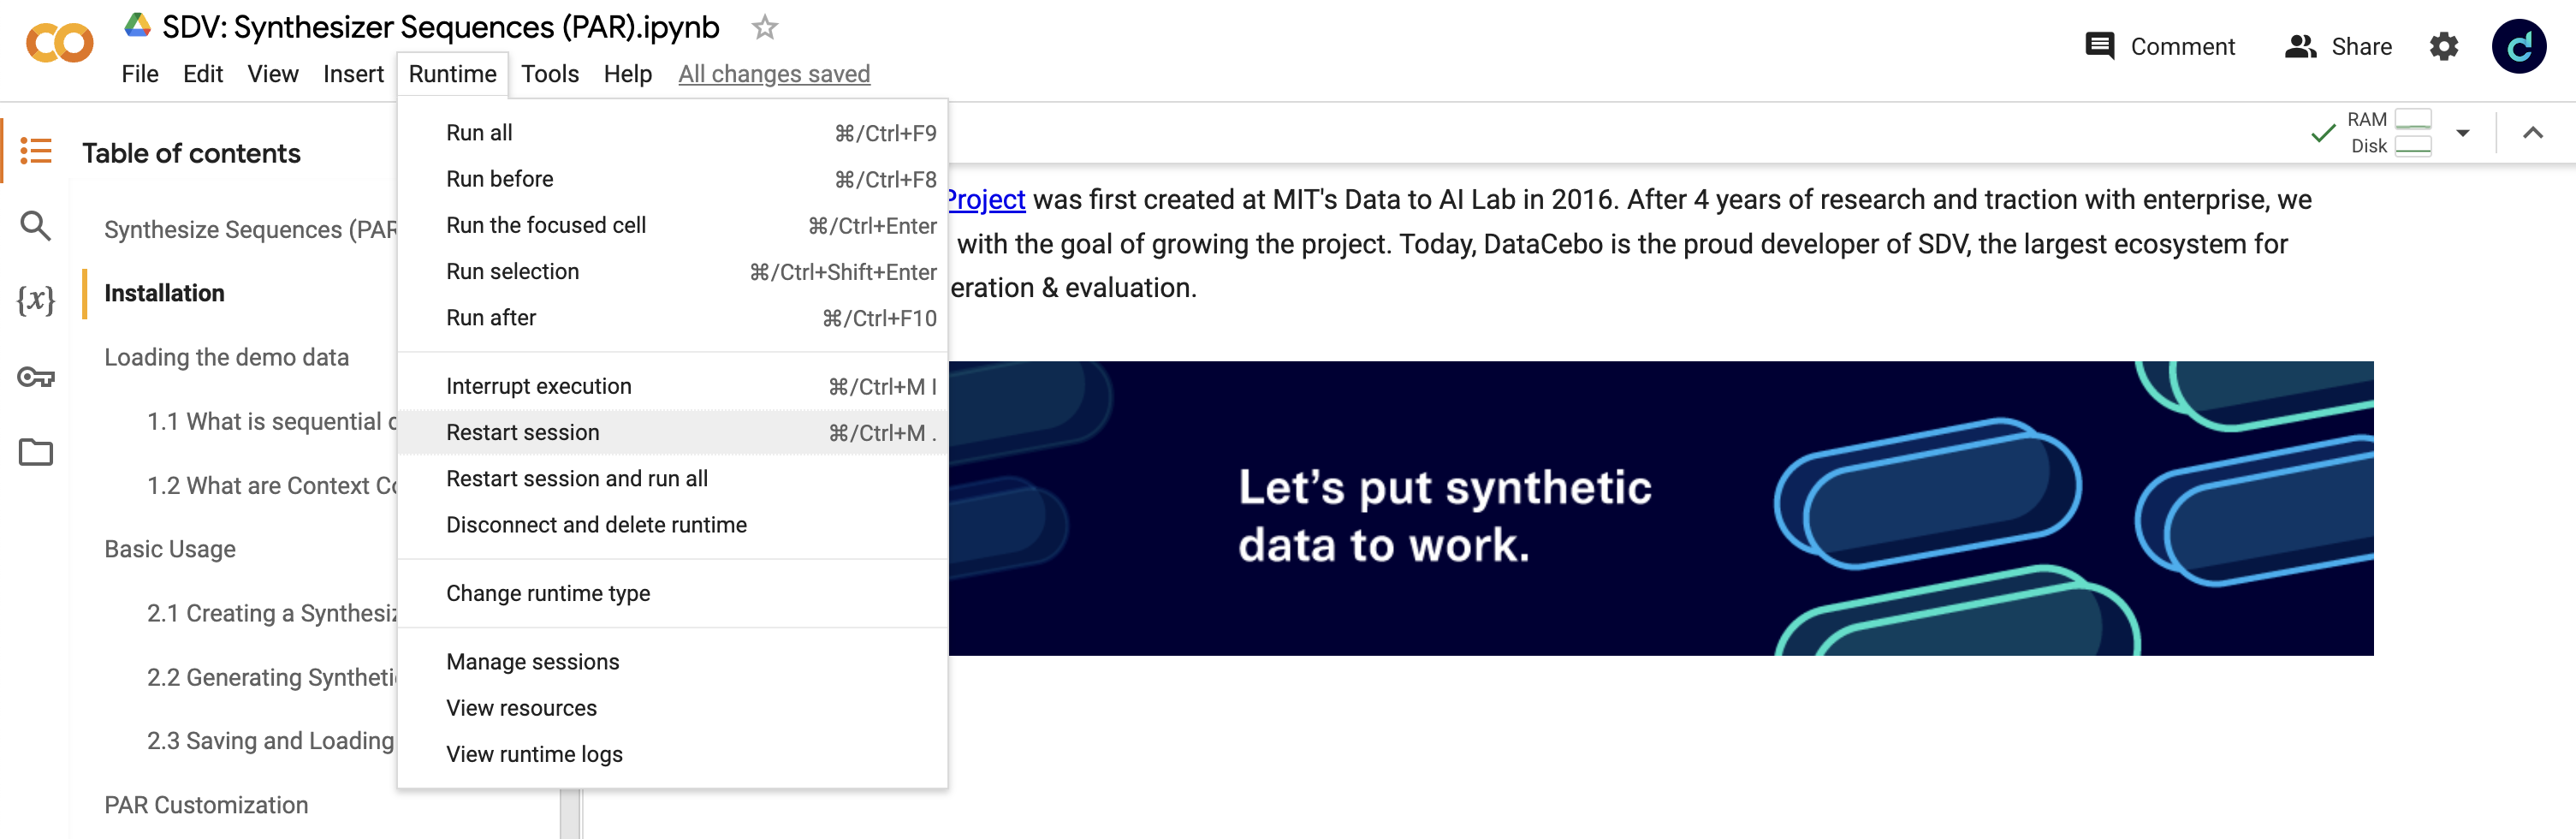

# 1. Loading the demo data
For this demo, we'll use a fake dataset that describes the daily prices of the 100 largest companies listed in the NASDAQ stock exchanges.

In [ ]:
from sdv.datasets.demo import download_demo

real_data, metadata = download_demo(
    modality='sequential',
    dataset_name='nasdaq100_2019'
)

**Details**: The data is available as a single table.
- `Symbol` describes the ticker symbol of the company
- `Date` describes the point of time that the prices correspond to
-  Columns such as `Open`, `Close` and `Volume` are measurements that change daily
- Columns such `Sector` and `Industry` describe fixed, unchanging values for every company

In [ ]:
real_data.head()

,Symbol,Date,Open,Close,Volume,MarketCap,Sector,Industry
0,AAPL,2018-12-31,39.632500,39.435001,140014000,7.378734e+11,Technology,Computer Manufacturing
1,AAPL,2019-01-02,38.722500,39.480000,148158800,7.378734e+11,Technology,Computer Manufacturing
2,AAPL,2019-01-03,35.994999,35.547501,365248800,7.378734e+11,Technology,Computer Manufacturing
3,AAPL,2019-01-04,36.132500,37.064999,234428400,7.378734e+11,Technology,Computer Manufacturing
4,AAPL,2019-01-07,37.174999,36.982498,219111200,7.378734e+11,Technology,Computer Manufacturing


The demo also includes **metadata**, a description of the dataset. It includes the data types for each column (called "sdtypes").

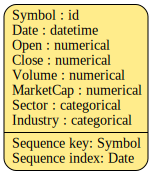

In [ ]:
metadata.visualize()

## 1.1 What is sequential data?

A **sequence** is a set of measurements taken in a particular order, such as the `Open`, `Close` and `Volume` of stock prices. Some datasets have a **sequence index** that prescribes this order. In our case, the `Date` column.

In a single sequence, all measurements belong to the same entity. For example, if we isolate only the stock from Amazon (`Symbol='AMZN'`), then we have a single sequence of data. This sequence has 252 measurements with a `Date` ranging from the end of 2018 to 2019 .

In [ ]:
amzn_sequence = real_data[real_data['Symbol'] == 'AMZN']
amzn_sequence

,Symbol,Date,Open,Close,Volume,MarketCap,Sector,Industry
252,AMZN,2018-12-31,1510.800049,1501.969971,6954500,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
253,AMZN,2019-01-02,1465.199951,1539.130005,7983100,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
254,AMZN,2019-01-03,1520.010010,1500.280029,6975600,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
255,AMZN,2019-01-04,1530.000000,1575.390015,9182600,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
256,AMZN,2019-01-07,1602.310059,1629.510010,7993200,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
...,...,...,...,...,...,...,...,...
499,AMZN,2019-12-23,1788.260010,1793.000000,2136400,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
500,AMZN,2019-12-24,1793.810059,1789.209961,881300,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
501,AMZN,2019-12-26,1801.010010,1868.770020,6005400,4.035002e+11,Consumer Services,Catalog/Specialty Distribution
502,AMZN,2019-12-27,1882.920044,1869.800049,6186600,4.035002e+11,Consumer Services,Catalog/Specialty Distribution


In a **multi-sequence** dataset, there are multiple sequences existing in the same table. For example, in our dataset, there are different sequences for each company: Amazon, Google, Netflix, etc.

A **sequence key** is a column that can be used to identify each sequence. In this case, the `Symbol` column. If we inspect it, we can see that it contains 100 unique values -- which means there are 100 sequences in the data.

In [ ]:
real_data['Symbol'].unique()

array(['AAPL', 'AMZN', 'MSFT', 'FB', 'TSLA', 'GOOGL', 'GOOG', 'NVDA',
       'ADBE', 'PYPL', 'NFLX', 'INTC', 'CMCSA', 'PEP', 'CSCO', 'COST',
       'AVGO', 'QCOM', 'TMUS', 'TXN', 'AMGN', 'CHTR', 'SBUX', 'AMD', 'ZM',
       'INTU', 'ISRG', 'MDLZ', 'GILD', 'JD', 'BKNG', 'VRTX', 'FISV',
       'ADP', 'ATVI', 'REGN', 'MELI', 'CSX', 'AMAT', 'MU', 'LRCX', 'ADSK',
       'ILMN', 'BIIB', 'ADI', 'DOCU', 'LULU', 'MNST', 'WDAY', 'CTSH',
       'EXC', 'EBAY', 'KHC', 'EA', 'NXPI', 'BIDU', 'XEL', 'DXCM', 'SGEN',
       'CTAS', 'IDXX', 'ORLY', 'SNPS', 'ROST', 'KLAC', 'SPLK', 'CDNS',
       'NTES', 'MAR', 'VRSK', 'WBA', 'PCAR', 'ASML', 'PAYX', 'MRNA',
       'ANSS', 'XLNX', 'MCHP', 'CPRT', 'ALXN', 'ALGN', 'FAST', 'SWKS',
       'SIRI', 'VRSN', 'PDD', 'CERN', 'DLTR', 'INCY', 'MXIM', 'TTWO',
       'CDW', 'CHKP', 'CTXS', 'TCOM', 'BMRN', 'ULTA', 'EXPE', 'WDC',
       'FOXA', 'LBTYK', 'FOX', 'LBTYA'], dtype=object)

**The PAR synthesizer is suited for multi-sequence data.** So this dataset with 100 sequences is a perfect candidate.

## 1.2 What are Context Columns?
A **context** column does not change during the course of a sequence.  In our case, `Sector` and `Industry` are context columns.

If we choose a sequence -- such as Amazon (`Symbol='AMZN'`) -- then we'll see that the context values don't change. Amazon is always a `'Consumer Services'` company.

In [ ]:
real_data[real_data['Symbol'] == 'AMZN']['Sector'].unique()

array(['Consumer Services'], dtype=object)

**The PAR Synthesizer learns sequence information based on the context.** It's important to identify these columns ahead of time.

# 2. Basic Usage

## 2.1 Creating a Synthesizer

An SDV **synthesizer** is an object that you can use to create synthetic data. It learns patterns from the real data and replicates them to generate synthetic data.

In [ ]:
from sdv.sequential import PARSynthesizer

synthesizer = PARSynthesizer(
    metadata,
    context_columns=['Sector', 'Industry'],
    verbose=True)

synthesizer.fit(real_data)

Loss (-1.230): 100%|██████████| 128/128 [03:03<00:00,  1.43s/it]


<font color="maroon"><i><b>This step takes about 5 min to complete.</b> We can use the `verbose` parameter to track progress. For larger datasets, this phase may take longer.</i></font>

When this code finishes running, the synthesizer is ready to use.

## 2.2 Generating Synthetic Data

Use the `sample` function and pass in any number of sequences to synthesize. The synthesizer algorithmically determines how long to make each sequence.

In [ ]:
synthetic_data = synthesizer.sample(num_sequences=10)
synthetic_data.head()

100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


,Symbol,Date,Open,Close,Volume,MarketCap,Sector,Industry
0,AAAA,2019-01-01,131.172670,129.014247,10318815,6.139517e+10,Consumer Non-Durables,Apparel
1,AAAA,2019-01-02,223.576975,127.503425,10000,9.693817e+09,Consumer Non-Durables,Apparel
2,AAAA,2019-01-04,164.503327,175.231407,4771557,2.320137e+10,Consumer Non-Durables,Apparel
3,AAAA,2019-01-05,175.819949,200.766169,2422652,2.096373e+10,Consumer Non-Durables,Apparel
4,AAAA,2019-01-06,202.319497,201.944810,10000,1.280168e+10,Consumer Non-Durables,Apparel


The synthesizer is generating entirely new sequences in the same format as the real data. **Each sequence represents an entirely new company** based on the overall patterns from the dataset. **_They do not map or correspond to any real company._**

For example, fictitious company `AAAA` is a generic Consumer Electronics/Video Chains company and `AAAB` is a Business Services company. A full list of our synthetic companies is shown below.

In [ ]:
synthetic_data[['Symbol', 'Industry']].groupby(['Symbol']).first().reset_index()

,Symbol,Industry
0,AAAA,Consumer Electronics/Video Chains
1,AAAB,Business Services
2,AAAC,Electronic Components
3,AAAD,None
4,AAAE,Industrial Specialties
5,AAAF,Diversified Commercial Services
6,AAAG,Business Services
7,AAAH,Industrial Specialties
8,AAAI,Department/Specialty Retail Stores
9,AAAJ,None


## 2.3 Saving and Loading
We can save the synthesizer to share with others and sample more synthetic data in the future.

In [ ]:
synthesizer.save('my_synthesizer.pkl')

synthesizer = PARSynthesizer.load('my_synthesizer.pkl')

# 3. PAR Customization

We can customizer our PARSynthesizer in many ways.

- Use the `epochs` parameter to make a tradeoff between training time and data quality. Higher epochs mean the synthesizer will train for longer, ideally improving the data quality.
- Use the `enforce_min_max_values` parameter to specify whether the synthesized data should always be within the same min/max ranges as the real data. Toggle this to `False` in order to enable forecasting.


In [ ]:
custom_synthesizer = PARSynthesizer(
    metadata,
    epochs=250,
    context_columns=['Sector', 'Industry'],
    enforce_min_max_values=False,
    verbose=True)

custom_synthesizer.fit(real_data)

Loss (-2.240): 100%|██████████| 250/250 [06:53<00:00,  1.65s/it]


<font color="maroon"><i><b>This step takes about 10 min to complete.</b> We can use the `verbose` parameter to track progress. For larger datasets, this phase may take longer.</i></font>

# 4. Sampling Options
Using the PAR synthesizer, you can customize the synthetic data to suit your needs.

## 4.1 Specify Sequence Length

By default, the synthesizer algorithmically determines the length of each sequence. However, you can also specify a fixed, predetermined length.

In [ ]:
custom_synthesizer.sample(num_sequences=3, sequence_length=2)

100%|██████████| 3/3 [00:00<00:00, 52.03it/s]


,Symbol,Date,Open,Close,Volume,MarketCap,Sector,Industry
0,AAAA,2019-01-01,183.437196,492.275292,-3341982,6.594948e+10,Consumer Non-Durables,Apparel
1,AAAA,2019-01-02,285.582241,352.907767,1248808,NaN,Consumer Non-Durables,Apparel
2,AAAB,2018-12-31,217.738543,87.049163,9424666,4.076160e+10,Health Care,Automotive Aftermarket
3,AAAB,2019-01-01,110.967387,154.038911,6146095,NaN,Health Care,Automotive Aftermarket
4,AAAC,2018-12-31,442.572144,101.384746,6569659,3.065645e+10,Technology,Television Services
5,AAAC,2019-01-02,267.859686,231.110761,-365182,3.807947e+10,Technology,Television Services


To forecast values into the future, specify a longer sequence length.

In [ ]:
long_sequence = custom_synthesizer.sample(num_sequences=1, sequence_length=500)

100%|██████████| 1/1 [00:14<00:00, 14.93s/it]


Now instead of ending at 2019 like the original data, we can see that the sequence goes until the end of 2022.

In [ ]:
long_sequence.tail()

,Symbol,Date,Open,Close,Volume,MarketCap,Sector,Industry
495,AAAD,2022-11-20,40.836821,16.981436,2615707,-6.888509e+09,Technology,RETAIL: Building Materials
496,AAAD,2022-11-23,44.821563,44.958103,8477314,4.177197e+08,Technology,RETAIL: Building Materials
497,AAAD,2022-11-27,55.323997,43.540539,4493082,-3.369012e+08,Technology,RETAIL: Building Materials
498,AAAD,2022-11-30,20.247359,14.986516,191755,4.008721e+09,Technology,RETAIL: Building Materials
499,AAAD,2022-12-03,44.083861,34.558706,5873583,9.699616e+08,Technology,RETAIL: Building Materials


## 4.2 Conditional Sampling Using Context

You can pass in context columns and allow the PAR synthesizer to simulate the sequence based on those values.

Let's start by creating a scenario with 2 companies in the Technology sector and 3 others in the Consumer Services sector. Each row corresponds to a new sequence that we want to synthesize.

In [ ]:
import pandas as pd

scenario_context = pd.DataFrame(data={
    'Symbol': ['COMPANY-A', 'COMPANY-B', 'COMPANY-C', 'COMPANY-D', 'COMPANY-E'],
    'Sector': ['Technology']*2 + ['Consumer Services']*3,
    'Industry': ['Computer Manufacturing', 'Computer Software: Prepackaged Software',
                 'Hotels/Resorts', 'Restaurants', 'Clothing/Shoe/Accessory Stores']
})

scenario_context

,Symbol,Sector,Industry
0,COMPANY-A,Technology,Computer Manufacturing
1,COMPANY-B,Technology,Computer Software: Prepackaged Software
2,COMPANY-C,Consumer Services,Hotels/Resorts
3,COMPANY-D,Consumer Services,Restaurants
4,COMPANY-E,Consumer Services,Clothing/Shoe/Accessory Stores


Now we can simulate this scenario using our trained synthesizer.

In [ ]:
custom_synthesizer.sample_sequential_columns(
    context_columns=scenario_context,
    sequence_length=2
)

100%|██████████| 5/5 [00:00<00:00, 46.09it/s]


,Symbol,Date,Open,Close,Volume,MarketCap,Sector,Industry
0,COMPANY-A,2018-12-31,55.820328,250.206434,13352594,1.739646e+11,Technology,Computer Manufacturing
1,COMPANY-A,2019-01-01,35.986537,221.401532,6569659,9.808632e+10,Technology,Computer Manufacturing
2,COMPANY-B,2019-01-01,77.041182,263.214593,-470725,3.915012e+10,Technology,Computer Software: Prepackaged Software
3,COMPANY-B,2019-01-02,202.292705,183.531971,1877328,7.586415e+10,Technology,Computer Software: Prepackaged Software
4,COMPANY-C,2018-12-31,243.816060,182.709383,1419486,-4.777236e+09,Consumer Services,Hotels/Resorts
5,COMPANY-C,2019-01-01,256.748141,183.531971,12849,7.581262e+09,Consumer Services,Hotels/Resorts
6,COMPANY-D,2018-12-31,89.581718,183.531971,8473219,1.031346e+11,Consumer Services,Restaurants
7,COMPANY-D,2019-01-01,133.503958,187.263592,6569659,8.110912e+10,Consumer Services,Restaurants
8,COMPANY-E,2018-12-31,183.437196,-62.386859,6569659,-3.896582e+10,Consumer Services,Clothing/Shoe/Accessory Stores
9,COMPANY-E,2019-01-01,86.495553,125.126907,6961487,1.654474e+10,Consumer Services,Clothing/Shoe/Accessory Stores


# 5. What's Next?

For more information about the PAR Synthesizer, visit the **[documentation](https://docs.sdv.dev/sdv/sequential-data/modeling/parsynthesizer)**.

**Need more help?** [Browse all tutorials](https://docs.sdv.dev/sdv/demos).


---

# About

The [Synthetic Data Vault Project](https://github.com/sdv-dev/SDV) was first created at MIT's Data to AI Lab in 2016. After 4 years of research and traction with enterprise, we created [DataCebo](https://datacebo.com/) in 2020 with the goal of growing the project. Today, DataCebo is the proud developer of SDV, the largest ecosystem for tabular synthetic data generation & evaluation.

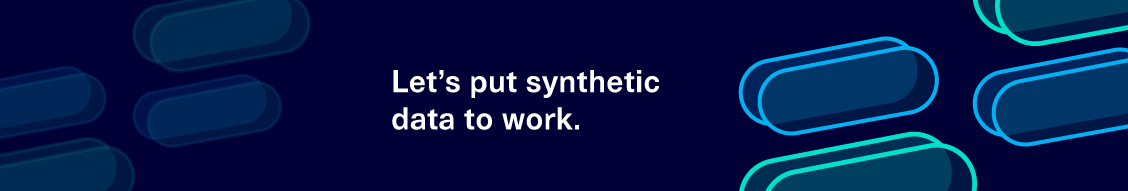